<a href="https://colab.research.google.com/github/johnson6314/NTHU_2023_DLBOI_HW/blob/main/2023_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Build an ANN for Chest X-ray Image Classification


## Introduction

Pneumonia is a prevalent lung infection, and its early detection is paramount to ensure prompt and suitable treatment. In this tutorial, we'll leverage PyTorch, a leading deep learning framework, to construct a classifier using a chest X-ray dataset that distinguishes whether a patient is diagnosed with pneumonia. This dataset encompasses two distinct classes, with each class housing 1,000 grayscale images.

By the culmination of this tutorial, you'll have the prowess to:
- Preprocess and load the dataset.
- Build and train a classifier utilizing PyTorch.
- Evaluate your developed model.

For a deeper dive into PyTorch and its functionalities, consider exploring the [official PyTorch website](https://pytorch.org/).

### References

- [Chest X-ray Pneumonia Dataset from Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download)


In [1]:
# Check your GPU status.
!nvidia-smi

Mon Sep 25 10:08:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/week6/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/week6/pneumonia.npy

--2023-09-25 10:08:55--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/week6/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M  --.-KB/s    in 0.1s    

2023-09-25 10:08:59 (422 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-09-25 10:08:59--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/week6/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M)

## A. Data Loading and Preprocessing

In this section, we'll go through the steps to load and preprocess the Chest X-ray dataset:

1. **Import Necessary Libraries**: We begin by importing the required Python modules such as `torch` and `numpy`.

2. **Load the Dataset**: The datasets for abnormal (indicative of pneumonia) and normal scans are loaded from their respective `.npy` files.

3. **Label Assignment**: For the purpose of binary classification:
   - Scans indicating the presence of pneumonia are labeled as `1`.
   - Scans that are normal are labeled as `0`.

4. **Data Splitting**: The dataset is then divided into training and validation sets, using a predefined `split_point` of 800.

5. **Conversion to PyTorch Tensors**: The numpy arrays of the images and labels are converted to PyTorch tensors to facilitate GPU-accelerated computations in the next steps.

6. **Dataset and DataLoader Creation**: Using PyTorch's `TensorDataset` and `DataLoader` utilities, we create datasets and data loaders for both training and validation data. This aids in easy batch processing and shuffling of the data during training.

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# 1000張肺炎與正常照片，取800張
split_point = 800

# 1000張照片取80%
# split_point = normal_scans*0.8

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


Size of the image is: torch.Size([256, 256])


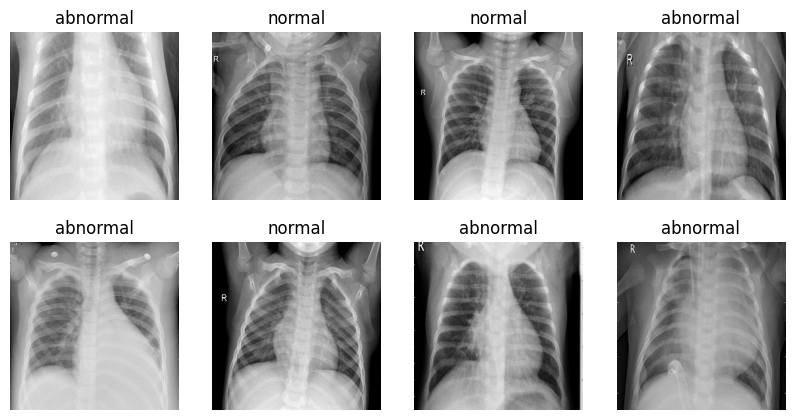

In [6]:
# Check images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for images, labels in train_loader:
    print("Size of the image is:", images[0].shape)
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.title(f"{'abnormal' if labels[i] else 'normal'}")
        plt.axis('off')
        plt.imshow(images[i], cmap='gray')
    break

## B. Defining Neural Networks in PyTorch

PyTorch offers the foundational module `torch.nn.Module` for designing neural networks. When it comes to defining a custom neural network, there are two primary approaches:

1. **Sequential Method**: Design your neural network as an ordered sequence of layers.
2. **Custom Class Method**: By extending `torch.nn.Module`, you can craft a network with more complex architectures and specific functionalities.

While the Sequential method is apt for standard networks where layers are stacked in order, the Custom Class method offers greater flexibility, allowing you to create intricate architectures.

### Common Layers in PyTorch:

* `Linear`: This represents a densely connected linear layer, similar to a single-layer perceptron.
* Activation Layers such as `Softmax`, `Sigmoid`, and `ReLU`: These layers introduce the needed non-linearity into the model.
* Additionally, PyTorch provides specialized layers tailored for specific architectures, including convolutional and recurrent layers, which we'll explore later in this course.

> **Note**: A unique feature of PyTorch is that many activation and loss functions are available in two forms: as **functions** (found in the `torch.nn.functional` namespace) and **as layers** (located in the `torch.nn` namespace). For activations, it's often more convenient to use the functional components from `torch.nn.functional` rather than instantiate separate layer objects.

In [7]:
import torch.nn as nn

# Model definition
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=1, bias=True)
)


## C. Training the Neural Network

In this section, we'll walk through the process of training and validating our neural network on the chest X-ray dataset. Here's a step-by-step breakdown:

1. **Setting Hyperparameters and Initialization**:
   - We'll be training our model for `30` epochs.
   - We initialize the `best_val_loss` as `infinity` to keep track of our best validation loss during training.

2. **Loss and Optimizer**:
   - We employ the `BCEWithLogitsLoss`, which is apt for binary classification tasks. This loss combines a sigmoid layer and the binary cross-entropy loss, making it more numerically stable than using them separately.
   - The optimizer of choice is `Adam`, with a learning rate of `1e-3`.
   - We'll also use a learning rate scheduler, `CosineAnnealingLR`, which adjusts the learning rate using a cosine annealing schedule.

3. **Training Loop**:
   - For each epoch, we put our model into training mode with `model.train()`.
   - We iterate over batches of data from our `train_loader`, sending the data to the GPU (with `.cuda()`), normalizing our images, and performing the forward and backward passes.
   - The gradients are then used to update the model's weights.

4. **Validation Loop**:
   - After training, we switch our model to evaluation mode using `model.eval()`.
   - We then evaluate our model's performance on the validation set. This involves forwarding our data through the model and computing the loss and accuracy.
   - The predictions are obtained by applying a threshold of `0.5` to the output sigmoid probabilities.

5. **Learning Rate Adjustment**:
   - After each epoch, we adjust the learning rate using our scheduler.

6. **Model Checkpointing**:
   - If our current model achieves a lower validation loss than our best recorded loss, we save this model as a checkpoint.

By the end of this training loop, we aim to have a trained model that performs well on our validation dataset, and we save the best-performing model to `model_classification.pth`.


In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate correct predictions for training data
        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)
            labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
            loss = criterion(outputs, labels_float)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels_float).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 2.8543, Train Accuracy: 71.25%, Val Loss: 0.2877, Val Accuracy: 90.00%
Epoch 2/30, Train Loss: 0.2500, Train Accuracy: 90.25%, Val Loss: 0.2191, Val Accuracy: 92.50%
Epoch 3/30, Train Loss: 0.2110, Train Accuracy: 92.06%, Val Loss: 0.2603, Val Accuracy: 90.00%
Epoch 4/30, Train Loss: 0.1483, Train Accuracy: 95.06%, Val Loss: 0.2847, Val Accuracy: 88.75%
Epoch 5/30, Train Loss: 0.2040, Train Accuracy: 91.88%, Val Loss: 0.3092, Val Accuracy: 88.50%
Epoch 6/30, Train Loss: 0.2336, Train Accuracy: 91.31%, Val Loss: 0.1814, Val Accuracy: 94.75%
Epoch 7/30, Train Loss: 0.2027, Train Accuracy: 92.56%, Val Loss: 0.1922, Val Accuracy: 93.50%
Epoch 8/30, Train Loss: 0.1485, Train Accuracy: 94.12%, Val Loss: 0.3244, Val Accuracy: 89.25%
Epoch 9/30, Train Loss: 0.1409, Train Accuracy: 94.31%, Val Loss: 0.1764, Val Accuracy: 94.75%
Epoch 10/30, Train Loss: 0.1248, Train Accuracy: 95.25%, Val Loss: 0.1833, Val Accuracy: 93.75%
Epoch 11/30, Train Loss: 0.1437, Train Accuracy: 

### Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.

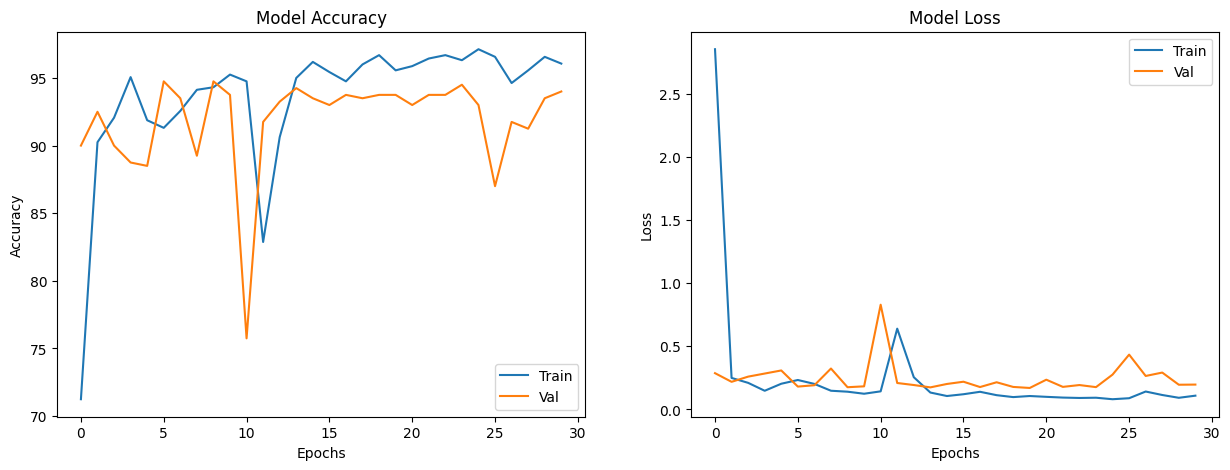

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(["Train", "Val"])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(["Train", "Val"])

plt.show()

## D. Model Evaluation with a Test Image

In this section, we'll evaluate our trained model using a random test image from the validation set to understand its prediction capability.

1. **Loading the Best Model**: We begin by loading the best model saved during training using the `load_state_dict` function.

2. **Random Image Selection**: A random index is chosen from the validation dataset, which will be used to fetch the corresponding X-ray image.

3. **Image Normalization**: Just like during the training process, we normalize our test image to ensure consistent input data distribution for the model.

4. **Prediction**: We pass the normalized test image through the model to obtain its prediction. Since the output of our model is in logits, we apply the `sigmoid` function to convert these logits to probabilities for our two classes - "normal" and "abnormal".

5. **Output Interpretation**:
We determine the model's final prediction by selecting the class with the highest confidence score.

6. **Visualization**: Lastly, we display the test image using `imshow` to have a visual understanding of what the model sees. The ground truth label for this image is also shown in the title for reference.

By repeatedly executing this section, you can evaluate the model's performance on different test images from the validation set and gain insight into its strengths and potential areas of improvement.


Take # 367 as test image.
This model is 66.66% confident that the scan is abnormal and 33.34% confident that the scan is normal.

Prediction is abnormal.
Incorrect 😢



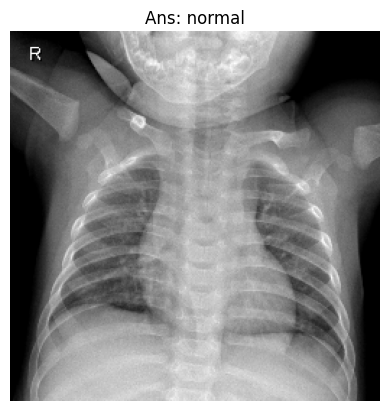

In [14]:
# Load best weights
model.load_state_dict(torch.load('model_classification.pth'))
model.eval()  # set the model to evaluation mode

index = np.random.randint(0, len(x_val))
print(f'Take # {index} as test image.')

# Normalize the image just like during training
test_image = (x_val[index] / 255.0).clone().detach().float().cuda()
test_image = test_image.unsqueeze(0)  # add batch dimension

# Model prediction
with torch.no_grad():
    prediction = model(test_image)
    prediction = torch.sigmoid(prediction)  # Convert logits to probabilities

class_names = ['normal', 'abnormal']
confidence = torch.sigmoid(prediction).squeeze().item()

print(f'This model is {round(100 * confidence, 2)}% confident that the scan is {class_names[1]} and {round(100 * (1 - confidence), 2)}% confident that the scan is {class_names[0]}.')

predicted_class = class_names[0] if confidence < 0.5 else class_names[1]

print()
print(f'Prediction is {predicted_class}.')
print(f'{"Correct 😊" if predicted_class == class_names[y_val[index].item()] else "Incorrect 😢"}')
print()

plt.axis('off')
plt.title(f"Ans: {'abnormal' if y_val[index] else 'normal'}")
plt.imshow(x_val[index], cmap='gray')  # Assuming the images are grayscale and channel-first
plt.show()

## Takeaways

1. **End-to-End Workflow**:
   - The tutorial presents a complete workflow of deep learning, from data loading and preprocessing to model construction, training, and evaluation. Each stage, including data normalization, labeling, and the selection of appropriate loss functions for specific tasks, is underscored for its significance.

2. **Model Evaluation & Visualization**:
   - Beyond just training, the tutorial underscores the importance of evaluating the trained model on unseen data and visualizing its performance metrics (like accuracy and loss). Such visualizations are instrumental in discerning model behavior across epochs, ensuring it's learning effectively and isn't succumbing to overfitting or underfitting.
